In [1]:
%pip install tensorboard --quiet
%pip install seaborn --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
sys.path.append('/workspace/cropClassification')
sys.path.append('/workspace/cropClassification/model')
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
import pandas as pd
from torch.utils.data import DataLoader

from unet_uncertain import UNetWithUncertainty, UNetWithFiLM
from compiler import ModelCompiler
from dataloader import RoadsideCropImageDataset
from loss import AleatoricLoss, BalancedCrossEntropyLoss, BalancedCrossEntropyUncertaintyLoss

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU with CUDA
    print("Using CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Apple M1/M2 GPU with MPS (Metal Performance Shaders)
    print("Using MPS")
else:
    device = torch.device("cpu")  # Fall back to CPU
    print("Using CPU")

Using CUDA


### Configuration

In [3]:
config = {
    "model": {
        "type": "UNetWithUncertainty",  # Example model type, replace with your actual model class name
        "params": {
            "in_channels": 9,  # Since we are using 9-channel input images
            "out_channels": 3   # Number of output classes for segmentation
        }
    },
    "training": {
        "epochs": 50,
        "batch_size": 32,
        "learning_rate": 0.1,
        "optimizer": {
            "type": "Adam",
            "params": {
                "lr": 0.1
            }
        },
        "scheduler": {
            "type": "StepLR",
            "params": {
                "step_size": 10,
                "gamma": 0.5
            }
        },
        "criterion": AleatoricLoss(), 
        "resume" : False,
        "resume_epoch" : None,
    },
    "validation": {
        "epochs": 50,
        "batch_size": 16
    },
    "dataset": {
        "train_csv": "/workspace/data/data/masked_data_csiss/training/train_chipping_csv_w_anc.csv",  # Path to the training DataFrame (includes npy file paths)
        "val_csv": "/workspace/data/data/masked_data_csiss/validation/validation_chipping_csv_w_anc.csv", # Path to the validation DataFrame (includes npy file paths)
        "train_root_path": "/workspace/data/data/masked_data_csiss/training",
        "val_root_path": "/workspace/data/data/masked_data_csiss/validation",
        "image_column": "img_chip_path",             # Column containing the image paths (npy files)
        "mask_column": "lbl_chip_path",              # Column containing the mask paths
        "train_mean": [93.8785585, 111.81092494, 76.94555781, 113.58929434, 206.93557473, 28.98472963,
                       46.53684269, 113.74437327, 116.23856585],  # Mean values for training set normalization
        "train_std": [53.24595916, 46.34658429, 45.91157286, 47.69937365, 82.32605363, 48.02506071,
                       22.46416468, 52.31732116, 47.89290138],   # Std values for training set normalization
        "val_mean": [88.62211239, 111.27628711, 75.19030815, 111.99622799, 223.21125121, 25.98495476, 
                     49.64829283, 115.91463906, 114.01573621],    # Mean values for validation set normalization
        "val_std": [53.97481266, 46.47043658, 45.64034871, 48.20284577, 59.89659002, 41.7467965,
                     20.82148233, 54.41768437, 47.68361442],     # Std values for validation set normalization
    },
    "evaluation": {
        "filename": "csiss_street_view_crop_classification.csv",  # Evaluation metrics to be used
        "class_mapping": {
            0: "Background",
            1: "Maize",
            2: "Soybean"
        }
    }
}


### Loading Datasets

In [4]:
train_df = pd.read_csv(config['dataset']['train_csv'])
val_df = pd.read_csv(config['dataset']['val_csv'])

In [5]:
train_dataset = RoadsideCropImageDataset(
    dataframe=train_df,
    root_dir=config['dataset']['train_root_path'],  # Root directory where images are stored
    usage='train',  # Indicates training dataset
    mean=config['dataset']['train_mean'],
    std=config['dataset']['train_std'],
    use_ancillary=True
)

val_dataset = RoadsideCropImageDataset(
    dataframe=val_df,
    root_dir=config['dataset']['val_root_path'],  # Root directory where images are stored
    usage='val',  # Indicates validation dataset
    mean=config['dataset']['val_mean'],
    std=config['dataset']['val_std'],
    use_ancillary=True
)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=config['training']['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['training']['batch_size'], shuffle=False)

### Construct Model and Training

##### With Uncertainty

In [ ]:
model = UNetWithUncertainty(n_channels=config['model']['params']['in_channels'],
                          n_classes=config['model']['params']['out_channels'],
                          ancillary_data_dim=3)
model_comp = ModelCompiler(model=model,
                           params_init=None)

In [ ]:
model_comp.fit(
    trainDataset=train_loader,
    valDataset=val_loader,
    epochs=config['training']['epochs'],
    optimizer_name=config['training']['optimizer']['type'],
    lr_init=config['training']['learning_rate'],
    lr_policy='steplr',  # Use 'steplr' as specified in config
    criterion=config['training']['criterion'],
    log=True,  # Enable logging for TensorBoard
    return_loss=False,
    use_ancillary=True,
    use_dropout=False,
    **config['training']['scheduler']['params'])

In [7]:
model = UNetWithUncertainty(n_channels=config['model']['params']['in_channels'],
                          n_classes=config['model']['params']['out_channels'],
                          ancillary_data_dim=3)
model_comp = ModelCompiler(model=model,
                           params_init="/workspace/notebook/outputs/UNetWithUncertainty_ep50/chkpt/50_checkpoint.pth.tar")

---------- GPU (CUDA) available ----------
Loading model parameters from: /workspace/notebook/outputs/UNetWithUncertainty_ep50/chkpt/50_checkpoint.pth.tar
Model parameters loaded successfully.
Total number of trainable parameters: 13.4M


/workspace/cropClassification/model/compiler.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(dir_params, map_location=torch.device('cpu'))


-------------------------- Start Evaluation --------------------------
Mean Uncertainty: 3.4820


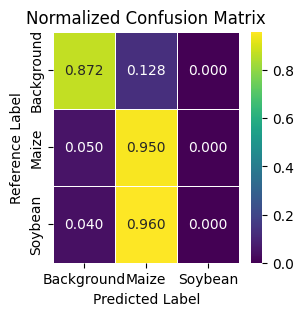

-------------------------- Evaluation Complete --------------------------
Overall Accuracy: 0.6222
Mean Accuracy: 0.6074
Mean IoU: 0.4276
Mean Precision: 0.4619
Mean Recall: 0.6074
Mean F1 Score: 0.5190
Mean Uncertainty: 3.4820


{'Overall Accuracy': np.float64(0.6222255049804987),
 'Mean Accuracy': np.float64(0.6073661949463353),
 'Mean IoU': np.float64(0.4276200333978502),
 'Mean Precision': np.float64(0.4618890337159079),
 'Mean Recall': np.float64(0.6073661949463353),
 'Mean F1 Score': np.float64(0.5189795409092861),
 'Mean Uncertainty': np.float64(3.4819534063339233)}

In [13]:
model_comp.evaluate(dataloader=val_loader,
                    num_classes=config['model']['params']['out_channels'],
                    out_name=config['evaluation']['filename'],  
                    class_mapping=config['evaluation']['class_mapping'],
                    log_uncertainty=True)

In [8]:
model_comp.predict_image("/workspace/data/data/all_sv_imgs/IMG_2022_004.jpg", )

AttributeError: 'ModelCompiler' object has no attribute 'predict_image'

##### With only Crop Calendar

In [8]:
model = UNetWithFiLM(n_channels=config['model']['params']['in_channels'],
                     n_classes=config['model']['params']['out_channels'],
                     ancillary_data_dim=3,
                     use_dropout=False)
model_comp = ModelCompiler(model=model,
                           params_init=None)

---------- GPU (CUDA) available ----------
Total number of trainable parameters: 13.4M


In [9]:
model_comp.fit(
    trainDataset=train_loader,
    valDataset=val_loader,
    epochs=config['training']['epochs'],
    optimizer_name=config['training']['optimizer']['type'],
    lr_init=config['training']['learning_rate'],
    lr_policy='steplr',  # Use 'steplr' as specified in config
    criterion=config['training']['criterion'],
    log=True,  # Enable logging for TensorBoard
    return_loss=False,
    use_ancillary=True,
    **config['training']['scheduler']['params'])

-------------------------- Start training --------------------------
----------------------- [1/50] -----------------------
Epoch Training Loss: 0.6669
Current Learning Rate: 0.100000
Validation Loss: 1.0722
Epoch 1 completed in 113.16 seconds
----------------------- [2/50] -----------------------
Epoch Training Loss: 0.6666
Current Learning Rate: 0.100000
Validation Loss: 0.8563
Epoch 2 completed in 112.37 seconds
----------------------- [3/50] -----------------------
Epoch Training Loss: 0.6028
Current Learning Rate: 0.100000
Validation Loss: 0.6365
Epoch 3 completed in 112.37 seconds
----------------------- [4/50] -----------------------
Epoch Training Loss: 0.6555
Current Learning Rate: 0.100000
Validation Loss: 2.1404
Epoch 4 completed in 112.38 seconds
----------------------- [5/50] -----------------------
Epoch Training Loss: 0.6399
Current Learning Rate: 0.100000
Validation Loss: 0.6368
Epoch 5 completed in 112.79 seconds
----------------------- [6/50] -----------------------
E

-------------------------- Start Evaluation --------------------------


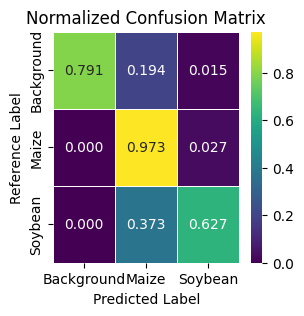

-------------------------- Evaluation Complete --------------------------
Overall Accuracy: 0.8255
Mean Accuracy: 0.7971
Mean IoU: 0.7078
Mean Precision: 0.8926
Mean Recall: 0.7971
Mean F1 Score: 0.8262


{'Overall Accuracy': np.float64(0.8254954338032054),
 'Mean Accuracy': np.float64(0.7971213222938252),
 'Mean IoU': np.float64(0.70777892725711),
 'Mean Precision': np.float64(0.8925509589246285),
 'Mean Recall': np.float64(0.7971213222938252),
 'Mean F1 Score': np.float64(0.8261959034767035)}

In [10]:
model_comp.evaluate(dataloader=val_loader,
                    num_classes=config['model']['params']['out_channels'],
                    class_mapping=config['evaluation']['class_mapping'],
                    out_name=config['evaluation']['filename'],  
                    log_uncertainty=True)